In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/msk_2024_mutations_clean.csv')
df

,Gene,Sample,Patient,mutationType,variantType,chr,startPosition,endPosition,proteinPosStart,proteinPosEnd,tumorAlleleFreq,normalAlleleFreq
0,PIK3CA,P-0000015-T01-IM3,P-0000015,Missense_Mutation,SNP,3,178936091,178936091,545,545,0.411765,0.000000
1,TP53,P-0000015-T01-IM3,P-0000015,Missense_Mutation,SNP,17,7577539,7577539,248,248,0.317708,0.000000
2,GATA3,P-0000015-T01-IM3,P-0000015,Frame_Shift_Ins,INS,10,8111513,8111514,333,335,0.165563,0.000000
3,ESR1,P-0000015-T01-IM3,P-0000015,Missense_Mutation,SNP,6,152419920,152419920,536,536,0.365854,0.000000
4,ALK,P-0000015-T01-IM3,P-0000015,Missense_Mutation,SNP,2,29450535,29450535,940,940,0.193416,0.001134
...,...,...,...,...,...,...,...,...,...,...,...,...
205544,YAP1,P-0009406-T01-IM3,P-0009406,Missense_Mutation,SNP,11,102056760,102056760,234,234,0.262338,0.000000
205545,ATM,P-0009406-T01-IM3,P-0009406,Missense_Mutation,SNP,11,108188190,108188190,2097,2097,0.187835,0.000000
205546,KMT2C,P-0009406-T01-IM3,P-0009406,Missense_Mutation,SNP,7,151874919,151874919,2540,2540,0.313312,0.000000
205547,KMT2C,P-0009406-T01-IM3,P-0009406,Frame_Shift_Del,DEL,7,151874913,151874913,2542,2542,0.316393,0.000000


In [3]:
# Add Gene Nodes
gene_counts = df['Gene'].value_counts(normalize=True)
genes_to_keep = gene_counts[gene_counts >= 0.001].index
df = df[df['Gene'].isin(genes_to_keep)]
print(f'Genes kept: {len(genes_to_keep)} out of {len(df["Gene"].unique())}')


Genes kept: 262 out of 262


In [4]:
import networkx as nx

G = nx.Graph()

for gene in df['Gene'].unique():
    G.add_node(gene)

# show the number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")

Number of nodes: 262


In [5]:
from itertools import combinations
from collections import Counter

# Group mutations by patient
patient_mutations = df.groupby("Patient")["Gene"].apply(list)

patient_mutations

duplicate_mutations = 0
single_mutations = 0

# for each patient, check if they have mutations in the same gene subtype
mutation_pairs = []
single_mutations_list = {}
for patient, mutations in patient_mutations.items():
    if len(mutations) > 1:
        list_len = len(mutations)
        set_len = len(set(mutations))
        if list_len != set_len:  # Check for duplicates
            duplicate_mutations += 1
    else:
        single_mutations += 1
        if mutations[0] not in single_mutations_list:
            single_mutations_list[mutations[0]] = 1
        else:
            single_mutations_list[mutations[0]] += 1

# Count occurrences of each mutation pair
print(f"Total patients with duplicate mutations: {duplicate_mutations}")
print(f"Total patients with single mutations: {single_mutations}")

Total patients with duplicate mutations: 6317
Total patients with single mutations: 2340


In [6]:
mutation_cooccurrence = Counter()

# preprocess patient mutations to count co-occurrences
# remove all duplicates from the mutation list for each patient, we are ignoring the details like start/end positions
# and only focusing on the unique mutation subtypes for co-occurrence analysis
patient_mutations = [list(set(mutations)) for mutations in patient_mutations]

# Iterate through each patient's mutations and count co-occurrences
for mutations in patient_mutations:
    for m1, m2 in combinations(mutations, 2):
        mutation_cooccurrence[(m1, m2)] += 1
        
print(f"Total unique mutation pairs: {len(mutation_cooccurrence)}")
print(mutation_cooccurrence.most_common(10))  # Show top 10 co-occurring mutation pairs

Total unique mutation pairs: 59807
[(('TP53', 'KRAS'), 4092), (('TP53', 'APC'), 3099), (('KRAS', 'APC'), 1878), (('PIK3CA', 'TP53'), 1534), (('SMAD4', 'TP53'), 1179), (('SMAD4', 'KRAS'), 997), (('CDKN2A', 'TP53'), 863), (('CDKN2A', 'KRAS'), 731), (('PIK3CA', 'APC'), 730), (('PIK3CA', 'KRAS'), 686)]


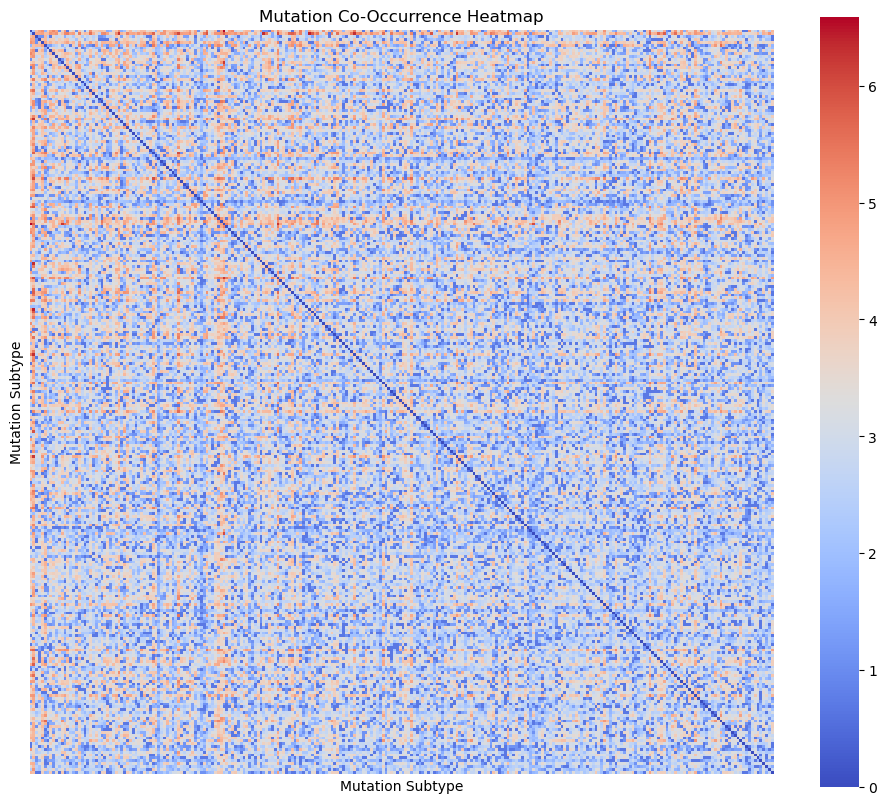

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert co-occurrence counts into a matrix
mutation_list = list(G.nodes())
cooccurrence_matrix = pd.DataFrame(np.zeros((len(mutation_list), len(mutation_list))), index=mutation_list, columns=mutation_list)
for (m1, m2), count in mutation_cooccurrence.items():
    cooccurrence_matrix.at[m1, m2] = count
    cooccurrence_matrix.at[m2, m1] = count  # Ensure symmetry
        
# log-transform the co-occurrence matrix for better visualization
cooccurrence_matrix = np.log1p(cooccurrence_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence_matrix, cmap="coolwarm", square=True, xticklabels=False, yticklabels=False)
plt.title("Mutation Co-Occurrence Heatmap")
plt.xlabel("Mutation Subtype")
plt.ylabel("Mutation Subtype")
plt.show()

In [8]:
co_occurrence_values = np.array(list(mutation_cooccurrence.values()))
# min_weight = co_occurrence_values.min()
# max_weight = co_occurrence_values.max()

# Avoid division by zero if all weights are the same
# if max_weight == min_weight:
#     max_weight += 1
    
# Normalize weights using log1p
normalized_weights = {pair: np.log1p(weight) for pair, weight in mutation_cooccurrence.items()}

for (m1, m2), norm_weight in normalized_weights.items():
    if m1 != m2: # Avoid self-loops
        G.add_edge(m1, m2, weight=norm_weight)

print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")

Total Nodes: 262
Total Edges: 34191


In [9]:
# Detect all self-loops
self_loops = list(nx.selfloop_edges(G))
print(f"Self-loops found: {self_loops}")
print(f"Total self-loops: {len(self_loops)}")

Self-loops found: []
Total self-loops: 0


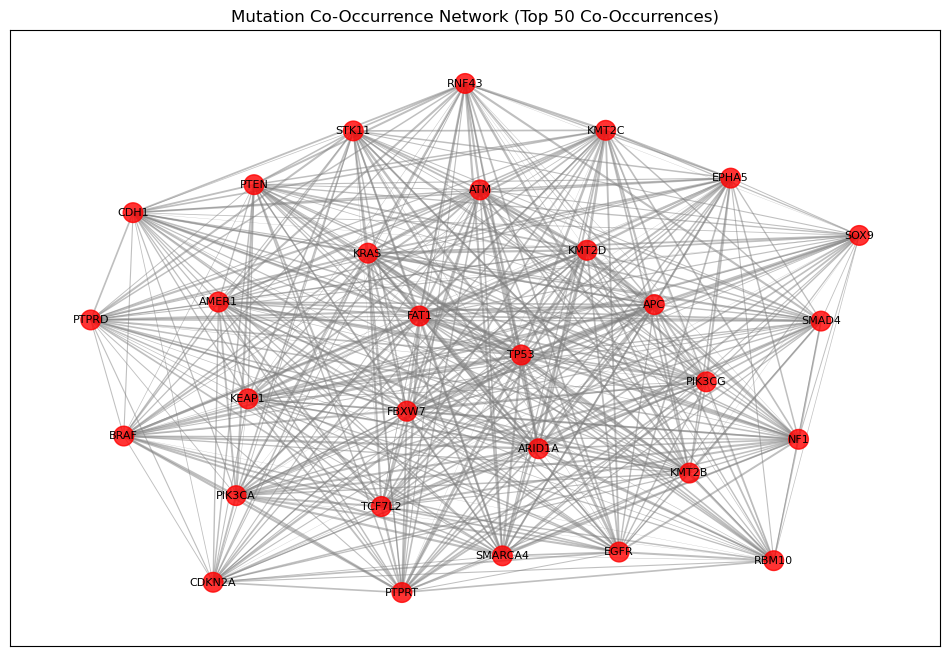

In [10]:
### **Step 4: Visualize a Subgraph of Highly Connected Mutations**
# Get the top 50 most frequently co-occurring mutation pairs
import matplotlib.pyplot as plt
top_mutation_pairs = sorted(mutation_cooccurrence, key=mutation_cooccurrence.get, reverse=True)[:50]

# Extract subgraph containing these mutations
subgraph_nodes = set()
for m1, m2 in top_mutation_pairs:
    subgraph_nodes.add(m1)
    subgraph_nodes.add(m2)

subgraph = G.subgraph(subgraph_nodes)

# Define node colors (all mutations are red)
node_colors = ["red" for _ in subgraph.nodes()]

# Get edge weights (co-occurrence frequency)
edges = nx.get_edge_attributes(subgraph, "weight")

# Apply force-directed layout
pos = nx.spring_layout(subgraph, seed=42, k=0.3)  # k controls node spacing

plt.figure(figsize=(12, 8))

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, node_size=200, node_color=node_colors, alpha=0.8)

# Draw edges with thickness based on weight
nx.draw_networkx_edges(subgraph, pos, alpha=0.5, width=[w * 0.3 for w in edges.values()], edge_color="gray")

# Draw labels for top mutations
labels = {node: node for node in subgraph.nodes()}
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8, font_color="black")

# Show plot
plt.title("Mutation Co-Occurrence Network (Top 50 Co-Occurrences)")
plt.show()

In [11]:
# Step 1: Filter Top 50% of Co-Occurrence Edges**
edges = list(G.edges(data=True))
edge_weights = np.array([edge[2]["weight"] for edge in edges])

# Compute the median weight (30th percentile) to use as a threshold
threshold = np.percentile(edge_weights, 70)  # Adjust this value to set your desired
print(f"Threshold for filtering: {threshold}")

# Keep only edges above the median weight
filtered_edges = [(u, v, d) for u, v, d in edges if d["weight"] >= threshold]
G_filtered = nx.Graph()
G_filtered.add_edges_from(filtered_edges)
print(f"Filtered graph has {G_filtered.number_of_nodes()} nodes and {G_filtered.number_of_edges()} edges.")


Threshold for filtering: 3.3672958299864737
Filtered graph has 262 nodes and 10306 edges.


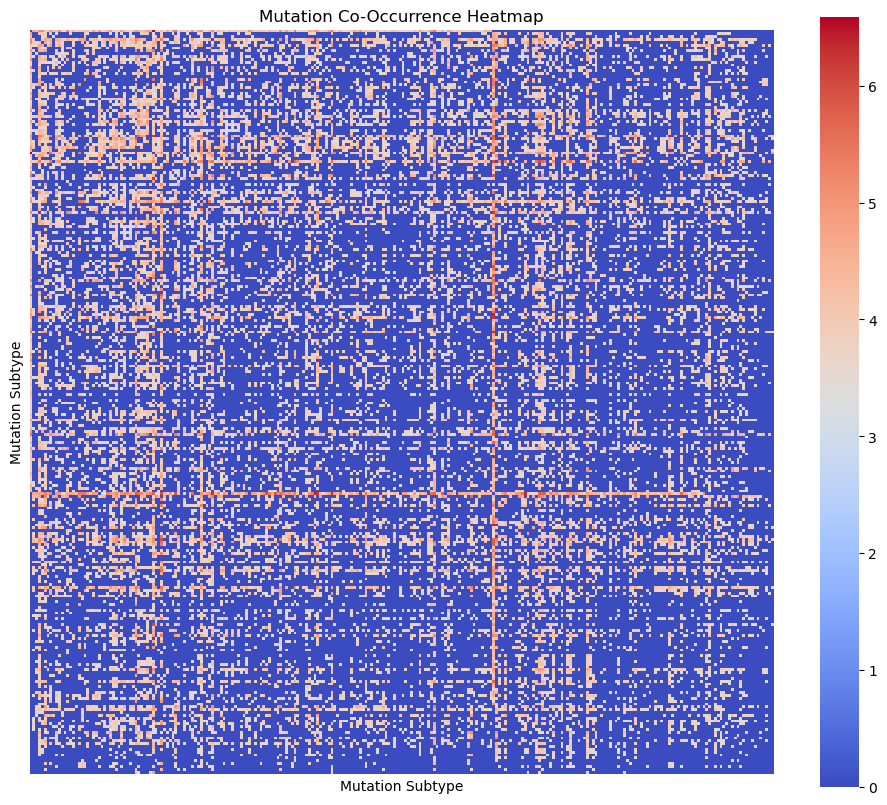

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert co-occurrence counts into a matrix
mutation_list = list(G_filtered.nodes())
cooccurrence_matrix = pd.DataFrame(np.zeros((len(mutation_list), len(mutation_list))), index=mutation_list, columns=mutation_list)

# Fill the matrix with edge weights
for m1, m2, count in G_filtered.edges(data='weight'):
    cooccurrence_matrix.at[m1, m2] = count
    cooccurrence_matrix.at[m2, m1] = count  # Ensure symmetry
    
# log-transform the co-occurrence matrix for better visualization
# cooccurrence_matrix = np.log1p(cooccurrence_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence_matrix, cmap="coolwarm", square=True, xticklabels=False, yticklabels=False)
plt.title("Mutation Co-Occurrence Heatmap")
plt.xlabel("Mutation Subtype")
plt.ylabel("Mutation Subtype")
plt.show()

In [22]:
import torch
from torch_geometric.utils import from_networkx, to_undirected

G = G_filtered
# Extract mutation counts from the original DataFrame
mutation_counts = df['Gene'].value_counts().to_dict()
# rank the mutations based on their counts
mutation_counts_sorted = sorted(mutation_counts.items(), key=lambda x: x[1], reverse=True)
print(f"Top mutations by count: {mutation_counts_sorted[:10]}")
# Create a mapping from mutation to index
mutation_to_index = {mutation: idx for idx, (mutation, _) in enumerate(mutation_counts_sorted)}
# one-hot encode the mutation counts
mutation_to_onehot = {mutation: np.zeros(len(mutation_counts_sorted)) for mutation in mutation_counts}
mutation_to_onehot.update({mutation: np.eye(len(mutation_counts_sorted))[idx] for mutation, idx in mutation_to_index.items()})
mutation_to_onehot

# Step 1: Extract one-hot encoded features for each gene (node)
feature_matrix = np.array([mutation_to_onehot[node] for node in G.nodes()])
feature_tensor = torch.tensor(feature_matrix, dtype=torch.float)


# Step 2: Convert NetworkX graph to PyTorch Geometric format
data = from_networkx(G, group_edge_attrs=["weight"])
data.edge_index = to_undirected(data.edge_index)  # Ensure bidirectional edges
data.x = feature_tensor  # Assign one-hot encoded features

# Step 3: Convert edge weights to PyTorch tensor
if 'weight' in data:
    data.edge_weight = torch.tensor([d['weight'] for _, _, d in G.edges(data=True)], dtype=torch.float)
    del data.weight  # Remove redundant edge attribute

print(data)  # Print the data object to check its contents

# Step 4: Save the processed graph data
save_path = "../data/msk_2024_graph_data_gene_one_hot.pt"
torch.save(data, save_path)

print(f"Processed graph saved at: {save_path}")
print(f"Graph Data Summary:\n  Nodes: {data.num_nodes}, Edges: {data.num_edges}, Feature Shape: {data.x.shape}")

Top mutations by count: [('TP53', 13783), ('KRAS', 7173), ('APC', 7136), ('PIK3CA', 4148), ('EGFR', 2534), ('KMT2D', 2351), ('ARID1A', 2181), ('KMT2C', 1944), ('SMAD4', 1915), ('ATM', 1669)]
Data(edge_index=[2, 20612], edge_attr=[20612, 1], num_nodes=262, x=[262, 262])
Processed graph saved at: ../data/msk_2024_graph_data_gene_one_hot.pt
Graph Data Summary:
  Nodes: 262, Edges: 20612, Feature Shape: torch.Size([262, 262])
